In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# plot MFs for clustering and lensing maps
from matplotlib import rcParams
rcParams['xtick.direction'] = 'in'
rcParams['xtick.major.size'] = 10
rcParams['xtick.minor.size'] = 5
rcParams['xtick.minor.visible'] = True
rcParams['ytick.direction'] = 'in'
rcParams['ytick.minor.size'] = 5
rcParams['ytick.minor.visible'] = True
rcParams['ytick.major.size'] = 10
rcParams['font.family'] = 'serif'
#rcParams['font.serif'] = ['Times New Roman']
rcParams['font.size'] = 12

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math
import os
from scipy.optimize import curve_fit

output_path = os.path.join(os.getcwd(), '2_Maps_Output')
parent_path = os.path.join(output_path, 'Simplified')
cov_path = os.path.join(output_path, 'cov_fix')

onemap_path = os.path.join(os.getcwd(), '1_Map_Output')

In [4]:
def likelihood_error(v_all_fixed,v_all_changing,array_len,itr=100,b=10):
        
    # fixed map mean    
    v_all_mean = np.zeros(array_len)
    for i in range(array_len):
        v_all_mean[i] = np.mean(v_all_fixed[:,i]) 

    # covariance
    cov = np.cov((v_all_fixed.transpose()))
    
    # singular covariance matrix workaround
    good = cov.diagonal() > 0
    cov2 = cov[good][:, good]

    # calculate the likelihood          
    L = np.zeros(b)
    N_ = itr-1           # number of realisations - 1
    p = array_len        # number of data points

    try:
        inv_cov = ((N_)/(N_ - p - 1)) * np.linalg.inv(cov)
        for i in range(b):
            L[i] = -0.5 * (v_all_changing[i] - v_all_mean) @ inv_cov @ (v_all_changing[i] - v_all_mean)
    except:
        inv_cov2 = ((N_)/(N_ - p - 1)) * np.linalg.inv(cov2)
        for i in range(b):
            d = (v_all_changing[i] - v_all_mean)[good]
            L[i] = -0.5 * d @ inv_cov2 @ d
            
    # calculate S_8  
    omega_m = np.linspace(0.2,0.4,b)
    sigma_8 = 0.8989639361571576*omega_m + 0.5303108191528527
    S_8 = sigma_8 * (omega_m/0.3)**0.5329788249790618 
    
    #coefficient = np.polyfit(S_8,L,2)
    popt, pcov = curve_fit(func,S_8,L)
    #print(popt,pcov)
    perr = np.sqrt(np.diag(pcov))
    a = abs(popt[0])
    e = perr[0]*(a**(-1.5))
    sigma = sqrt(1/(2*a))
    
    return sigma,e 

def func(x, a, b, c):
    return a*x**2 + b*x + c

### 1. Threshold

/opt/conda/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


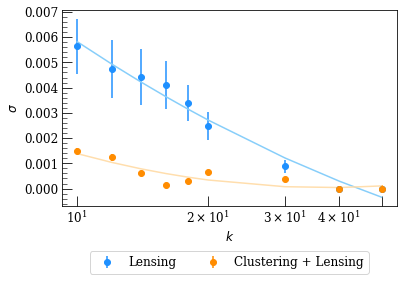

In [5]:
# one map
nside = 256
N = 12*nside*nside
smoothing = 20
t = [10,12,14,16,18,20,30,40,50]
t_array = np.array(t)

def load_t(path,map_len):
    
    cp = np.zeros(len(t_array))
    e = np.zeros(len(t_array))
    sigma = np.zeros(len(t_array))
    for i,t in enumerate(t_array):
        sub_path = os.path.join(path, f't{t}_n{nside}_s{smoothing}')
        v_all_fixed = np.loadtxt(os.path.join(sub_path, 'v_all_fixed.out'))
        v_all_changing = np.loadtxt(os.path.join(sub_path, 'v_all_changing'))
        output = np.loadtxt(os.path.join(sub_path, 'c.out'))
        cp[i] = output[3]
        array_len = t * map_len * 3
        sigma[i],e[i] = likelihood_error(v_all_fixed,v_all_changing,array_len)  
    return sigma,e,cp

x = t_array
x_log = log(x)
y1 = load_t(onemap_path,1)[2]
e1 = load_t(onemap_path,1)[1]
y2 = load_t(cov_path,2)[2]
e2 = load_t(cov_path,2)[1]

coefficient1 = np.polyfit(x_log,y1,2)
poly1 = np.poly1d(coefficient1)     
new_y1 = poly1(x_log)

coefficient2 = np.polyfit(x_log,y2,2)
poly2 = np.poly1d(coefficient2)     
new_y2 = poly2(x_log)

fig = plt.figure()
ax = plt.subplot(111)
ax.errorbar(x,y1,yerr = e1,fmt='o',color='dodgerblue',ecolor='dodgerblue',label='Lensing')
ax.plot(x, new_y1, color='lightskyblue')
ax.errorbar(x,y2,yerr = e2,fmt='o',color='darkorange',ecolor='darkorange',label='Clustering + Lensing')
ax.plot(x, new_y2,color='navajowhite')
ax.set_xscale('log')
ax.set_xlabel('$k$')
ax.set_ylabel('$\sigma$')
ax.set_xticks([10,20,30,40,50])
#ax.set_title('Constraining Power vs. Threshold Count \n')
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,box.width, box.height * 0.9])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=False, ncol=5)
plt.show()

In [116]:
print(load_t(onemap_path,t),'\n',load_t(cov_path,t))

[5.63167713e-03 4.74777077e-03 4.41567595e-03 4.10952666e-03
 3.38070348e-03 2.47878672e-03 8.76487910e-04 9.11622792e-10
 9.84963674e-10] 
 [1.49439535e-03 1.24451684e-03 6.03726741e-04 1.30301222e-04
 2.79140257e-10 5.01851292e-10 4.85936936e-10 7.40141662e-10
 4.52054130e-10]


In [7]:
print(load_t(onemap_path,1)[1],load_t(cov_path,2)[1])

/opt/conda/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[0.00107639 0.00114261 0.00111807 0.00095649 0.00070709 0.00055216
 0.00025493        inf        inf] [9.87614789e-05 1.42147993e-04 7.81985142e-05 1.74453355e-05
 2.48572837e-05 2.04960578e-05 5.15275665e-05 9.68040998e-05
 1.57766143e-04]


# 2. Smoothing

In [6]:
omega_m = np.linspace(0.2,0.4,10)
sigma_8 = 0.8989639361571576*omega_m + 0.5303108191528527
S_8 = sigma_8 * (omega_m/0.3)**0.5329788249790618

In [7]:
thr_ct = 10
nside = 256
smoothing_array = np.linspace(10,60,11,dtype=int)

def load_s(path,map_len):
    array_len = thr_ct * map_len * 3
    cp1 = np.zeros(len(smoothing_array))
    e = np.zeros(len(smoothing_array))
    sigma = np.zeros(len(smoothing_array))
    for i,smoothing in enumerate(smoothing_array):
        sub_path = os.path.join(path, f't{thr_ct}_n{nside}_s{smoothing}')
        v_all_fixed = np.loadtxt(os.path.join(sub_path, 'v_all_fixed.out'))
        v_all_changing = np.loadtxt(os.path.join(sub_path, 'v_all_changing'))
        output = np.loadtxt(os.path.join(sub_path, 'c.out'))
        cp1[i] = output[3]
        sigma[i],e[i] = likelihood_error(v_all_fixed,v_all_changing,array_len)  
    return sigma,e,cp1

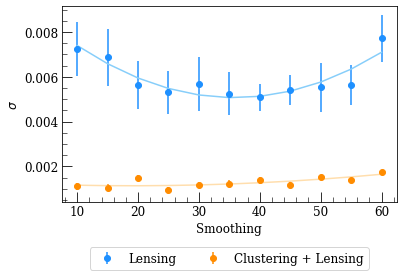

In [31]:
x = smoothing_array
y1 = load_s(onemap_path,1)[0]
e1 = load_s(onemap_path,1)[1]
y2 = load_s(cov_path,2)[0]
e2 = load_s(cov_path,2)[1]

coefficient1 = np.polyfit(x,y1,2)
poly1 = np.poly1d(coefficient1)     
new_y1 = poly1(x)

coefficient2 = np.polyfit(x,y2,2)
poly2 = np.poly1d(coefficient2)     
new_y2 = poly2(x)

fig = plt.figure()
ax = plt.subplot(111)

ax.errorbar(x,y1,yerr = e1,fmt='o',color='dodgerblue',ecolor='dodgerblue',label='Lensing')
ax.plot(x, new_y1, color='lightskyblue')
ax.errorbar(x,y2,yerr = e2,fmt='o',color='darkorange',ecolor='darkorange',label='Clustering + Lensing')
ax.plot(x, new_y2,color='navajowhite')
ax.set_xlabel('Smoothing')
ax.set_ylabel('$\sigma$')
#ax.set_title('Constraining Power vs. Smoothing \n')
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,box.width, box.height * 0.9])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=False, ncol=5)
plt.show()

In [32]:
print(e1,'\n \n', e2)

[0.00120682 0.00127319 0.00107639 0.00095372 0.00120773 0.00093911
 0.00059156 0.00067617 0.0011092  0.00091207 0.00103481] 
 
 [1.56351235e-04 1.51304212e-04 9.87614789e-05 1.31773347e-04
 1.28826690e-04 1.50094977e-04 1.52231825e-04 1.41146255e-04
 7.23391786e-05 8.10578156e-05 8.98506759e-05]


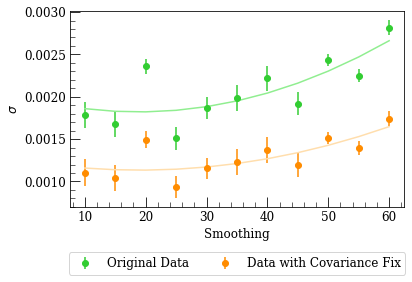

In [317]:
x = smoothing_array
y1 = load_s(parent_path,2)[2]
e1 = load_s(parent_path,2)[1]
y2 = load_s(cov_path,2)[2]
e2 = load_s(cov_path,2)[1]

coefficient1 = np.polyfit(x,y1,2)
poly1 = np.poly1d(coefficient1)     
new_y1 = poly1(x)

coefficient2 = np.polyfit(x,y2,2)
poly2 = np.poly1d(coefficient2)     
new_y2 = poly2(x)

fig = plt.figure()
ax = plt.subplot(111)

ax.errorbar(x,y1,yerr = e1,fmt='o',color='limegreen',ecolor='limegreen',label='Original Data')
ax.plot(x, new_y1, color='lightgreen')
ax.errorbar(x,y2,yerr = e2,fmt='o',color='darkorange',ecolor='darkorange',label='Data with Covariance Fix')
ax.plot(x, new_y2,color='navajowhite')
ax.set_xlabel('Smoothing')
ax.set_ylabel('$\sigma$')
#ax.set_title('Constraining Power vs. Smoothing for Combined Maps (Testing Covariance Fix) \n')
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,box.width, box.height * 0.9])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=False, ncol=5)
plt.show()

### 3. nside

In [8]:
nside_array = [256,512,1024]
thr_ct = 10
smoothing = 20


def load_n(path,map_len):
    array_len = thr_ct * map_len * 3
    cp = np.zeros(len(nside_array))
    e = np.zeros(len(nside_array))
    sigma = np.zeros(len(nside_array))
    for i,nside in enumerate(nside_array):
        sub_path = os.path.join(path, f't{thr_ct}_n{nside}_s{smoothing}')
        v_all_fixed = np.loadtxt(os.path.join(sub_path, 'v_all_fixed.out'))
        v_all_changing = np.loadtxt(os.path.join(sub_path, 'v_all_changing'))
        output = np.loadtxt(os.path.join(sub_path, 'c.out'))
        cp[i] = output[3]
        sigma[i],e[i] = likelihood_error(v_all_fixed,v_all_changing,array_len)  
    return sigma,e,cp

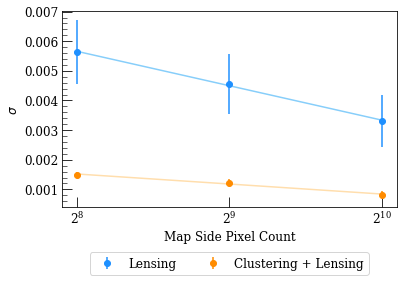

In [28]:
x = log2(np.array(nside_array)) 
y1 = load_n(onemap_path,1)[0]
e1 = load_n(onemap_path,1)[1]
y2 = load_n(cov_path,2)[0]
e2 = load_n(cov_path,2)[1]

m1, b1 = np.polyfit(x, y1, 1)
m2, b2 = np.polyfit(x, y2, 1)

fig = plt.figure()
ax = plt.subplot(111)

ax.errorbar(nside_array,y1,yerr = e1,fmt='o',color='dodgerblue',ecolor='dodgerblue',label='Lensing')
ax.plot(nside_array, m1*x + b1, color='lightskyblue')
ax.errorbar(nside_array,y2,yerr = e2,fmt='o',color='darkorange',ecolor='darkorange',label='Clustering + Lensing')
ax.plot(nside_array, m2*x + b2,color='navajowhite')
ax.set_xscale('log',basex=2)
ax.set_xlabel('Map Side Pixel Count') 
ax.set_ylabel('$\sigma$')
#ax.set_title('Constraining Power vs. Number of Pixels \n')
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,box.width, box.height * 0.9])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=False, ncol=5)
plt.show()

In [11]:
print(load_n(onemap_path,1)[1],'\n',load_n(cov_path,2)[1])

[0.00107639 0.00101037 0.00087074] 
 [9.87614789e-05 1.08244809e-04 1.15677044e-04]


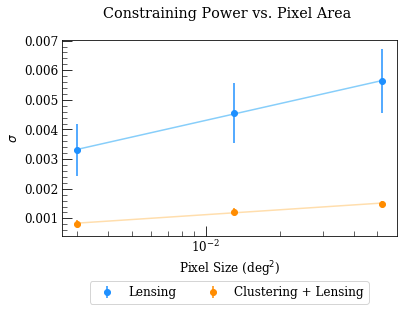

In [33]:
nside_array1 = [0.052,0.013,0.003]

x = log2(np.array(nside_array1))
y1 = load_n(onemap_path,1)[0]
e1 = load_n(onemap_path,1)[1]
y2 = load_n(cov_path,2)[0]
e2 = load_n(cov_path,2)[1]

m1, b1 = np.polyfit(x, y1, 1)
m2, b2 = np.polyfit(x, y2, 1)

fig = plt.figure()
ax = plt.subplot(111)

ax.errorbar(nside_array1,y1,yerr = e1,fmt='o',color='dodgerblue',ecolor='dodgerblue',label='Lensing')
ax.plot(nside_array1, m1*x + b1, color='lightskyblue')
ax.errorbar(nside_array1,y2,yerr = e2,fmt='o',color='darkorange',ecolor='darkorange',label='Clustering + Lensing')
ax.plot(nside_array1, m2*x + b2,color='navajowhite')
ax.set_xscale('log')#,basex=2)
ax.set_xlabel('Pixel Size (deg$^2$)') 
ax.set_ylabel('$\sigma$')
ax.set_title('Constraining Power vs. Pixel Area \n')
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,box.width, box.height * 0.9])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=False, ncol=5)
plt.show()

### 4. Sky Fraction

In [12]:
nside=512
thr_ct = 10
smoothing = 20
N_p = 12*nside*nside
f_array = [int(floor(0.01*N_p)),int(floor(0.02*N_p)),int(floor(0.03*N_p)),int(floor(0.04*N_p)),int(floor(0.05*N_p)),
          int(floor(0.06*N_p)),int(floor(0.07*N_p)),int(floor(0.08*N_p)),int(floor(0.09*N_p)),int(floor(0.1*N_p)),
           int(floor(0.2*N_p)),int(floor(0.3*N_p)),int(floor(0.4*N_p)),int(floor(0.5*N_p))]

def load_sf(f_array,path,map_len):
    array_len = thr_ct * map_len * 3
    cp = np.zeros(len(f_array))
    e = np.zeros(len(f_array))
    sigma = np.zeros(len(f_array))
    for i,f in enumerate(f_array):
        sub_path = os.path.join(path, f't{thr_ct}_n{nside}_s{smoothing}_f{f}')
        v_all_fixed = np.loadtxt(os.path.join(sub_path, 'v_all_fixed.out'))
        v_all_changing = np.loadtxt(os.path.join(sub_path, 'v_all_changing'))
        output = np.loadtxt(os.path.join(sub_path, 'c.out'))
        cp[i] = output[3]
        sigma[i],e[i] = likelihood_error(v_all_fixed,v_all_changing,array_len)  
    return sigma,e,cp

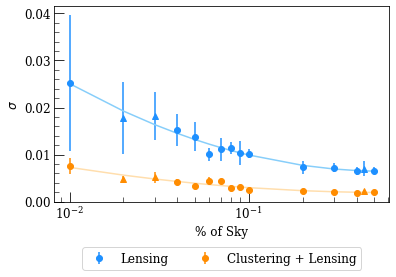

In [13]:
frac = np.array(f_array)/N_p

x = log(frac)
y1 = load_sf(f_array,onemap_path,1)[0]
y2 = load_sf(f_array,cov_path,2)[0]


coefficient1 = np.polyfit(x,y1,2)
poly1 = np.poly1d(coefficient1)     
new_y1 = poly1(x)

coefficient2 = np.polyfit(x,y2,2)
poly2 = np.poly1d(coefficient2)     
new_y2 = poly2(x)

fake_x = [int(floor(0.01*N_p)),int(floor(0.04*N_p)),int(floor(0.05*N_p)),
          int(floor(0.06*N_p)),int(floor(0.07*N_p)),int(floor(0.08*N_p)),int(floor(0.09*N_p)),int(floor(0.1*N_p)),
           int(floor(0.2*N_p)),int(floor(0.3*N_p)),int(floor(0.4*N_p)),int(floor(0.5*N_p))]
real_x = [int(floor(0.02*N_p)),int(floor(0.03*N_p)),int(floor(0.44*N_p))]

fake_x_plot = np.array(fake_x)/N_p
real_x_plot = np.array(real_x)/N_p

fake_y1 = load_sf(fake_x,onemap_path,1)[0]
fake_e1 = load_sf(fake_x,onemap_path,1)[1]
fake_y2 = load_sf(fake_x,cov_path,2)[0]
fake_e2 = load_sf(fake_x,cov_path,2)[1]

real_y1 = load_sf(real_x,onemap_path,1)[0]
real_e1 = load_sf(real_x,onemap_path,1)[1]
real_y2 = load_sf(real_x,cov_path,2)[0]
real_e2 = load_sf(real_x,cov_path,2)[1]


fig = plt.figure()
ax = plt.subplot(111)

ax.errorbar(fake_x_plot,fake_y1,yerr = fake_e1,fmt='o',color='dodgerblue',label='Lensing')
ax.plot(frac, new_y1, color='lightskyblue')
ax.errorbar(fake_x_plot,fake_y2,yerr = fake_e2,fmt='o',color='darkorange',label='Clustering + Lensing')
ax.plot(frac, new_y2,color='navajowhite')
ax.errorbar(real_x_plot,real_y1,yerr=real_e1,fmt='^',color='dodgerblue')
ax.errorbar(real_x_plot,real_y2,yerr=real_e2,fmt='^',color='darkorange')
#ax.set_xticks(x)
ax.set_xscale('log')
ax.set_xlabel('% of Sky')
ax.set_ylabel('$\sigma$')
#ax.set_title('Constraining Power vs. Fraction of Sky \n')
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,box.width, box.height * 0.9])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=False, ncol=5)
plt.show()

In [16]:
print(load_sf(f_array,onemap_path,1)[1],'\n',load_sf(f_array,cov_path,2)[1])

[0.01447655 0.0076442  0.0050586  0.00338025 0.00307203 0.00140049
 0.0024682  0.00134278 0.00245915 0.00098789 0.00141797 0.0008971
 0.00091436 0.00078893] 
 [0.00168345 0.00069705 0.00114517 0.00050501 0.00026506 0.00083571
 0.00033314 0.00048167 0.00041734 0.00020521 0.00012888 0.00019142
 0.00010116 0.00017981]


#### Looking at just V1 & V2 - Smoothing

In [17]:
def load_v12(thr_ct,nside,smoothing,is_one):
    
    if is_one == True:
        map_len = 1
        parent_path = os.path.join(os.getcwd(), '1_Map_Output')

    else:
        map_len = 2
        output_path = os.path.join(os.getcwd(), '2_Maps_Output')
        parent_path = os.path.join(output_path, 'cov_fix')
    
    array_len = map_len*thr_ct*2

    # parent folder for input variable combination
    path = os.path.join(parent_path, f't{thr_ct}_n{nside}_s{smoothing}')

    v_all_fixed = np.loadtxt(os.path.join(path, 'V_all_fixed.out'))
    v_all = np.loadtxt(os.path.join(path, 'v_all_changing'))
    
    vf_12 = np.hstack((v_all_fixed[:,10:30],v_all_fixed[:,40:60]))
    v_12 = np.hstack((v_all[:,10:30],v_all[:,40:60]))

    v_all_mean = np.zeros(array_len)
    for i in range(array_len):
        v_all_mean[i] = mean(vf_12[:,i])
        
    # calculate S_8  
    omega_m = np.linspace(0.2,0.4,b)
    sigma_8 = 0.8989639361571576*omega_m + 0.5303108191528527
    S_8 = sigma_8 * (omega_m/0.3)**0.5329788249790618 
    
    # covariance
    cov = np.cov((vf_12.transpose()))

    # singular covariance matrix workaround
    good = cov.diagonal() > 0
    cov2 = cov[good][:, good]

    # calculate the likelihood          
    L = np.zeros(b)
    N_ = itr-1           # number of realisations - 1
    p = array_len        # number of data points

    try:
        inv_cov = ((N_)/(N_ - p - 1)) * np.linalg.inv(cov)
        for i in range(b):
            L[i] = -0.5 * (v_12[i] - v_all_mean) @ inv_cov @ (v_12[i] - v_all_mean)
    except:
        inv_cov2 = ((N_)/(N_ - p - 1)) * np.linalg.inv(cov2)
        for i in range(b):
            d = (v_12[i] - v_all_mean)[good]
            L[i] = -0.5 * d @ inv_cov2 @ d

    popt, pcov = curve_fit(func,S_8,L)
    #print(popt,pcov)
    perr = np.sqrt(np.diag(pcov))
    a = abs(popt[0])
    e = perr[0]*(a**(-1.5))
    sigma = sqrt(1/(2*a))
    return sigma,e 
    
    #coefficient = np.polyfit(S_8,L,2)
    #constraining_power = np.sqrt(-1 / (2*coefficient[0]))
    #return constraining_power


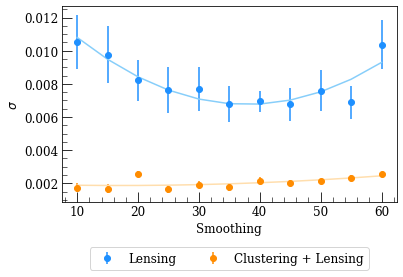

In [19]:
# using smoothing to test v1,v2
thr_ct = 10
nside = 256
b=10
itr=100

smooth = np.linspace(10,60,11,dtype=int)
v12_smooth1 = np.zeros(len(smooth))
v12_smooth2 = np.zeros(len(smooth))
v12_e1 = np.zeros(len(smooth))
v12_e2 = np.zeros(len(smooth))
for index,i in enumerate(smooth):
    v12_smooth1[index] = load_v12(thr_ct,nside,i,is_one=True)[0]
    v12_smooth2[index] = load_v12(thr_ct,nside,i,is_one=False)[0]
    v12_e1[index] = load_v12(thr_ct,nside,i,is_one=True)[1]
    v12_e2[index] = load_v12(thr_ct,nside,i,is_one=False)[1]

x = smooth
y1 = v12_smooth1
y2 = v12_smooth2

coefficient1 = np.polyfit(x,y1,2)
poly1 = np.poly1d(coefficient1)     
new_y1 = poly1(x)

coefficient2 = np.polyfit(x,y2,2)
poly2 = np.poly1d(coefficient2)     
new_y2 = poly2(x)

fig = plt.figure()
ax = plt.subplot(111)

ax.errorbar(x,y1,yerr =v12_e1,fmt='o',color='dodgerblue',ecolor='dodgerblue',label='Lensing')
ax.plot(x, new_y1, color='lightskyblue')
ax.errorbar(x,y2,yerr =v12_e2,fmt='o',color='darkorange',ecolor='darkorange',label='Clustering + Lensing')
ax.plot(x, new_y2,color='navajowhite')
ax.set_xlabel('Smoothing')
ax.set_ylabel('$\sigma$')
#ax.set_title('Constraining Power vs. Smoothing for V1 & V2 only \n')
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,box.width, box.height * 0.9])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=False, ncol=5)
plt.show()

In [21]:
print(v12_e1,'\n \n',v12_e2)

[0.00162149 0.0017093  0.00125683 0.00138866 0.00131631 0.00109179
 0.00065477 0.00099071 0.00124165 0.00098978 0.00147531] 
 
 [0.00026466 0.00026274 0.00014709 0.00025661 0.00022618 0.0002221
 0.00021432 0.00017981 0.00010453 0.00018995 0.00016022]


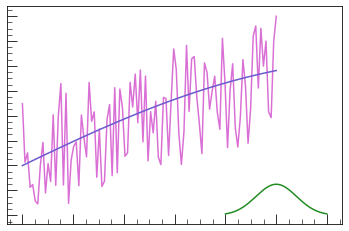

In [136]:
from scipy.stats import norm
x = np.linspace(0,.1,100)
noise = exp(5*x)-1
for index,n in enumerate(noise):
    noise[index] = n + np.random.random(1)
    
# plot noise
plt.plot(x,noise,color='orchid')

# plot curve thru noise
plt.plot(x,sin(10*x+.15)+.25,color='slateblue')
plt.tick_params(labelbottom=False) 
plt.tick_params(labelleft=False) 

# plot little gaussian
x_axis = np.arange(0.08, 0.12, 0.0001)
plt.plot(x_axis, .005*norm.pdf(x_axis,.1,.008),color='forestgreen')
plt.show()

### plots without errorbars

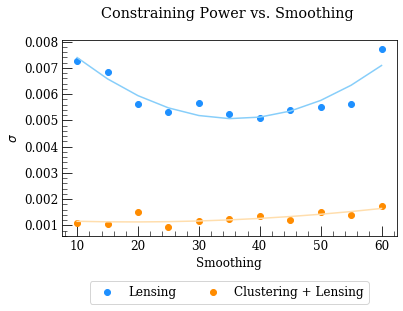

In [156]:
x = smoothing_array
y1 = load_smoothing(onemap_path)
y2 = load_smoothing(cov_path)

coefficient1 = np.polyfit(x,y1,2)
poly1 = np.poly1d(coefficient1)     
new_y1 = poly1(x)

coefficient2 = np.polyfit(x,y2,2)
poly2 = np.poly1d(coefficient2)     
new_y2 = poly2(x)

fig = plt.figure()
ax = plt.subplot(111)

ax.plot(x,y1,'o',color='dodgerblue',label='Lensing')
ax.plot(x, new_y1, color='lightskyblue')
ax.plot(x,y2,'o',color='darkorange',label='Clustering + Lensing')
ax.plot(x, new_y2,color='navajowhite')
ax.set_xlabel('Smoothing')
ax.set_ylabel('$\sigma$')
ax.set_title('Constraining Power vs. Smoothing \n')
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,box.width, box.height * 0.9])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=False, ncol=5)
plt.show()

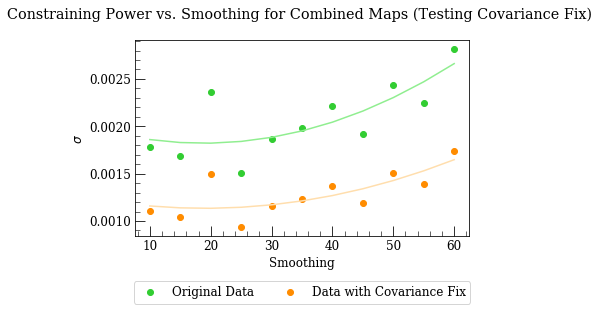

In [233]:
def load_smoothing(path):
    cp2 = np.zeros(len(smoothing_array))
    for i,smoothing in enumerate(smoothing_array):
        sub_path = os.path.join(path, f't{thr_ct}_n{nside}_s{smoothing}')
        output = np.loadtxt(os.path.join(sub_path, 'c.out'))
        cp2[i] = output[3]
    return cp2

x = smoothing_array
y1 = load_smoothing(parent_path)
y2 = load_smoothing(cov_path)

coefficient1 = np.polyfit(x,y1,2)
poly1 = np.poly1d(coefficient1)     
new_y1 = poly1(x)

coefficient2 = np.polyfit(x,y2,2)
poly2 = np.poly1d(coefficient2)     
new_y2 = poly2(x)

fig = plt.figure()
ax = plt.subplot(111)

ax.plot(x,y1,'o',color='limegreen',label='Original Data')
ax.plot(x, new_y1, color='lightgreen')
ax.plot(x,y2,'o',color='darkorange',label='Data with Covariance Fix')
ax.plot(x, new_y2,color='navajowhite')
ax.set_xlabel('Smoothing')
ax.set_ylabel('$\sigma$')
ax.set_title('Constraining Power vs. Smoothing for Combined Maps (Testing Covariance Fix) \n')
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,box.width, box.height * 0.9])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=False, ncol=5)
plt.show()

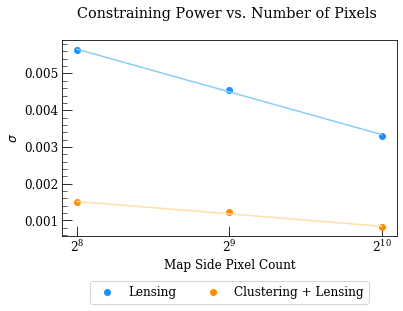

In [161]:
def load_nside(path):
    cp = np.zeros(len(nside_array))
    for i,nside in enumerate(nside_array):
        sub_path = os.path.join(path, f't{thr_ct}_n{nside}_s{smoothing}')
        output = np.loadtxt(os.path.join(sub_path, 'c.out'))
        cp[i] = output[3]
    return cp

x = log2(np.array(nside_array)) 
y1 = load_nside(onemap_path)
y2 = load_nside(cov_path)

m1, b1 = np.polyfit(x, y1, 1)
m2, b2 = np.polyfit(x, y2, 1)

fig = plt.figure()
ax = plt.subplot(111)

ax.plot(nside_array,y1,'o',color='dodgerblue',label='Lensing')
ax.plot(nside_array, m1*x + b1, color='lightskyblue')
ax.plot(nside_array,y2,'o',color='darkorange',label='Clustering + Lensing')
ax.plot(nside_array, m2*x + b2,color='navajowhite')
ax.set_xscale('log',basex=2)
ax.set_xlabel('Map Side Pixel Count') 
ax.set_ylabel('$\sigma$')
ax.set_title('Constraining Power vs. Number of Pixels \n')
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,box.width, box.height * 0.9])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=False, ncol=5)
plt.show()

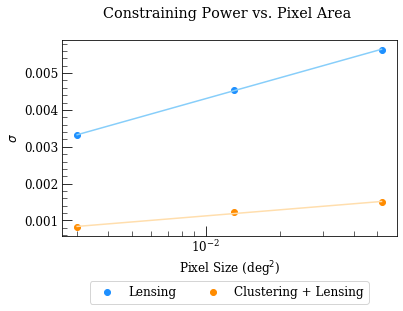

In [289]:
#nside_array1 = [786432,3145728,12582912]
nside_array1 = [0.052,0.013,0.003]

x = log2(np.array(nside_array1)) 
y1 = load_nside(onemap_path)
y2 = load_nside(cov_path)

m1, b1 = np.polyfit(x, y1, 1)
m2, b2 = np.polyfit(x, y2, 1)

fig = plt.figure()
ax = plt.subplot(111)

ax.plot(nside_array1,y1,'o',color='dodgerblue',label='Lensing')
ax.plot(nside_array1, m1*x + b1, color='lightskyblue')
ax.plot(nside_array1,y2,'o',color='darkorange',label='Clustering + Lensing')
ax.plot(nside_array1, m2*x + b2,color='navajowhite')
ax.set_xscale('log')#,basex=2)
ax.set_xlabel('Pixel Size (deg$^2$)') 
ax.set_ylabel('$\sigma$')
ax.set_title('Constraining Power vs. Pixel Area \n')
#ax.set_xticks(nside_array1)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,box.width, box.height * 0.9])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=False, ncol=5)
plt.show()

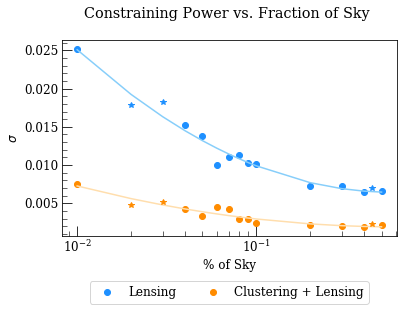

In [167]:
def load_sky_frac(f_array,path):
    f_array_plot = np.array(f_array)/N_p
    cp = np.zeros(len(f_array))
    for i,f in enumerate(f_array):
        sub_path = os.path.join(path, f't{thr_ct}_n{nside}_s{smoothing}_f{f}')
        output = np.loadtxt(os.path.join(sub_path, 'c.out'))
        cp[i] = output[3]
    return f_array_plot,cp

frac = load_sky_frac(f_array,onemap_path)[0]
x = log(frac)
y1 = load_sky_frac(f_array,onemap_path)[1]
y2 = load_sky_frac(f_array,cov_path)[1]

coefficient1 = np.polyfit(x,y1,2)
poly1 = np.poly1d(coefficient1)     
new_y1 = poly1(x)

coefficient2 = np.polyfit(x,y2,2)
poly2 = np.poly1d(coefficient2)     
new_y2 = poly2(x)

fake_x = [int(floor(0.01*N_p)),int(floor(0.04*N_p)),int(floor(0.05*N_p)),
          int(floor(0.06*N_p)),int(floor(0.07*N_p)),int(floor(0.08*N_p)),int(floor(0.09*N_p)),int(floor(0.1*N_p)),
           int(floor(0.2*N_p)),int(floor(0.3*N_p)),int(floor(0.4*N_p)),int(floor(0.5*N_p))]
real_x = [int(floor(0.02*N_p)),int(floor(0.03*N_p)),int(floor(0.44*N_p))]

fake_x_plot = (load_sky_frac(fake_x,onemap_path)[0])
real_x_plot = (load_sky_frac(real_x,cov_path)[0])

fake_y1 = load_sky_frac(fake_x,onemap_path)[1]
fake_y2 = load_sky_frac(fake_x,cov_path)[1]

real_y1 = load_sky_frac(real_x,onemap_path)[1]
real_y2 = load_sky_frac(real_x,cov_path)[1]


fig = plt.figure()
ax = plt.subplot(111)

ax.plot(fake_x_plot,fake_y1,'o',color='dodgerblue',label='Lensing')
ax.plot(frac, new_y1, color='lightskyblue')
ax.plot(fake_x_plot,fake_y2,'o',color='darkorange',label='Clustering + Lensing')
ax.plot(frac, new_y2,color='navajowhite')
ax.plot(real_x_plot,real_y1,'*',color='dodgerblue')
ax.plot(real_x_plot,real_y2,'*',color='darkorange')
#ax.set_xticks(x)
ax.set_xscale('log')
ax.set_xlabel('% of Sky')
ax.set_ylabel('$\sigma$')
ax.set_title('Constraining Power vs. Fraction of Sky \n')
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,box.width, box.height * 0.9])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=False, ncol=5)
plt.show()

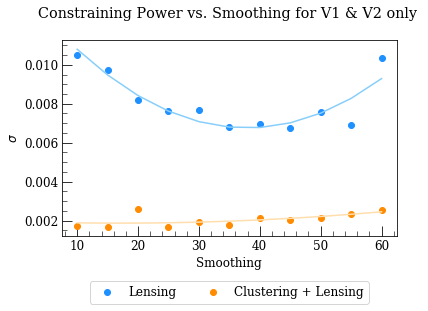

In [308]:
# using smoothing to test v1,v2
thr_ct = 10
nside = 256
b=10
itr=100

smooth = np.linspace(10,60,11,dtype=int)
v12_sigma1 = np.zeros(len(smooth))
v12_sigma2 = np.zeros(len(smooth))
v12_e1 = np.zeros(len(smooth))
v12_e2 = np.zeros(len(smooth))
for index,i in enumerate(smooth):
    v12_smooth1[index] = load_v12(thr_ct,nside,i,is_one=True)[0]
    v12_smooth2[index] = load_v12(thr_ct,nside,i,is_one=False)[0]
    v12_e1[index] = load_v12(thr_ct,nside,i,is_one=True)[1]
    v12_e2[index] = load_v12(thr_ct,nside,i,is_one=False)[1]

x = smooth
y1 = v12_smooth1
y2 = v12_smooth2

coefficient1 = np.polyfit(x,y1,2)
poly1 = np.poly1d(coefficient1)     
new_y1 = poly1(x)

coefficient2 = np.polyfit(x,y2,2)
poly2 = np.poly1d(coefficient2)     
new_y2 = poly2(x)

fig = plt.figure()
ax = plt.subplot(111)

ax.plot(x,y1,'o',color='dodgerblue',label='Lensing')
ax.plot(x, new_y1, color='lightskyblue')
ax.plot(x,y2,'o',color='darkorange',label='Clustering + Lensing')
ax.plot(x, new_y2,color='navajowhite')
ax.set_xlabel('Smoothing')
ax.set_ylabel('$\sigma$')
ax.set_title('Constraining Power vs. Smoothing for V1 & V2 only \n')
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,box.width, box.height * 0.9])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=False, ncol=5)
plt.show()

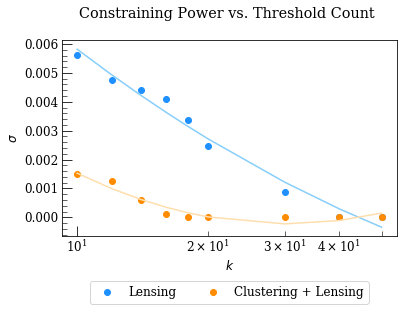

In [315]:
smoothing = 20
t = [10,12,14,16,18,20,30,40,50]

def load_threshold(path,t):
    cp1 = np.zeros(len(t))
    for i,thr_ct in enumerate(t):
        sub_path = os.path.join(path, f't{thr_ct}_n{nside}_s{smoothing}')
        output = np.loadtxt(os.path.join(sub_path, 'c.out'))
        cp1[i] = output[3]
    return cp1

x = np.array(t)
x_log = log(x)
y1 = load_threshold(onemap_path,t)
y2 = load_threshold(cov_path,t)

coefficient1 = np.polyfit(x_log,y1,2)
poly1 = np.poly1d(coefficient1)     
new_y1 = poly1(x_log)

coefficient2 = np.polyfit(x_log,y2,2)
poly2 = np.poly1d(coefficient2)     
new_y2 = poly2(x_log)

fig = plt.figure()
ax = plt.subplot(111)
ax.plot(x,y1,'o',color='dodgerblue',label='Lensing')
ax.plot(x, new_y1, color='lightskyblue')
ax.plot(x,y2,'o',color='darkorange',label='Clustering + Lensing')
ax.plot(x, new_y2,color='navajowhite')
ax.set_xscale('log')
ax.set_xlabel('$k$')
ax.set_ylabel('$\sigma$')
#ax.set_xticks(t)
ax.set_title('Constraining Power vs. Threshold Count \n')
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,box.width, box.height * 0.9])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=False, ncol=5)
plt.show()